In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
from collections import namedtuple

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
max_tile_size = 512
bs = 16

In [5]:
path = Path("dataset_segmentation/")
path_lbl = path / "labels"
path_img = path / "images"

In [6]:
def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [7]:
ImageTile = namedtuple('ImageTile', 'path idx rows cols')


def calc_n_tiles(size, tile_max_size):
    # TODO check and test this
    x, y = size
    n_cols = x % (x // tile_max_size + 1)
    n_rows = y % (y // tile_max_size + 1)
    return n_rows, n_cols, (x//n_cols, y//n_rows)


def get_labels_tiles(fn):
    path, *tile = fn
    path = path_lbl / path.name
    return ImageTile(path, *tile)


def get_tiles(images: PathOrStr, rows: int, cols: int) -> Collection[ImageTile]:
    images_tiles = []
    for img in images:
        for i in range(rows * cols):
            images_tiles.append(ImageTile(img, i, rows, cols))
    return images_tiles


def open_image_tile(img_t: ImageTile, mask=False, **kwargs) -> Image:
    """given and ImageTile it returns and Image with the tile,
    set mask to True for masks"""
    path, idx, rows, cols = img_t
    img = open_image(path, **kwargs) if not mask else open_mask(path, **kwargs)
    row = idx // cols
    col = idx % cols
    tile_x = img.size[0] // cols
    tile_y = img.size[1] // rows
    return Image(img.data[:, col * tile_x:(col + 1) * tile_x, row * tile_y:(row + 1) * tile_y])


class SegmentationTileLabelList(SegmentationLabelList):

    def open(self, fn: ImageTile):
        return open_image_tile(fn, div=True, mask=True)


class SegmentationTileItemList(ImageList):
    _label_cls, _square_show_res = SegmentationTileLabelList, False

    # accepts as inputs a tuple of TileInfo and PathOrStr
    def open(self, fn: ImageTile) -> Image:
        return open_image_tile(fn, convert_mode=self.convert_mode, after_open=self.after_open)

    @classmethod
    def from_folder(cls, path: PathOrStr = '.', rows=1, cols=1, extensions: Collection[str] = None, **kwargs) -> ItemList:
        """Create an `ItemList` in `path` from the filenames that have a suffix in `extensions`.
        `recurse` determines if we search subfolders."""
        files = get_files(path, extensions, recurse=True)
        files_tiled = get_tiles(files, rows, cols)
        return SegmentationTileItemList(files_tiled, **kwargs)



In [8]:
#calc number tiles with hardcoded sizes
rows, cols, tile_size = calc_n_tiles((2219, 3149 ), max_tile_size)
print(tile_size)

(554, 524)


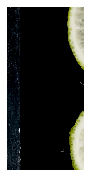

In [9]:
st = SegmentationTileItemList.from_folder(path_img, rows, cols)
i = st[2]
st.split_by_rand_pct()
show_image(i)

TODO add tranforms and debug get_transforms() issues

In [10]:
codes = ['background','fruit']
data = (SegmentationTileItemList
    .from_folder(path_img, 4,6)
    .split_by_rand_pct()
    .label_from_func(get_labels_tiles, classes=codes)
    .transform([])
    .databunch(bs=bs)
    .normalize(imagenet_stats))


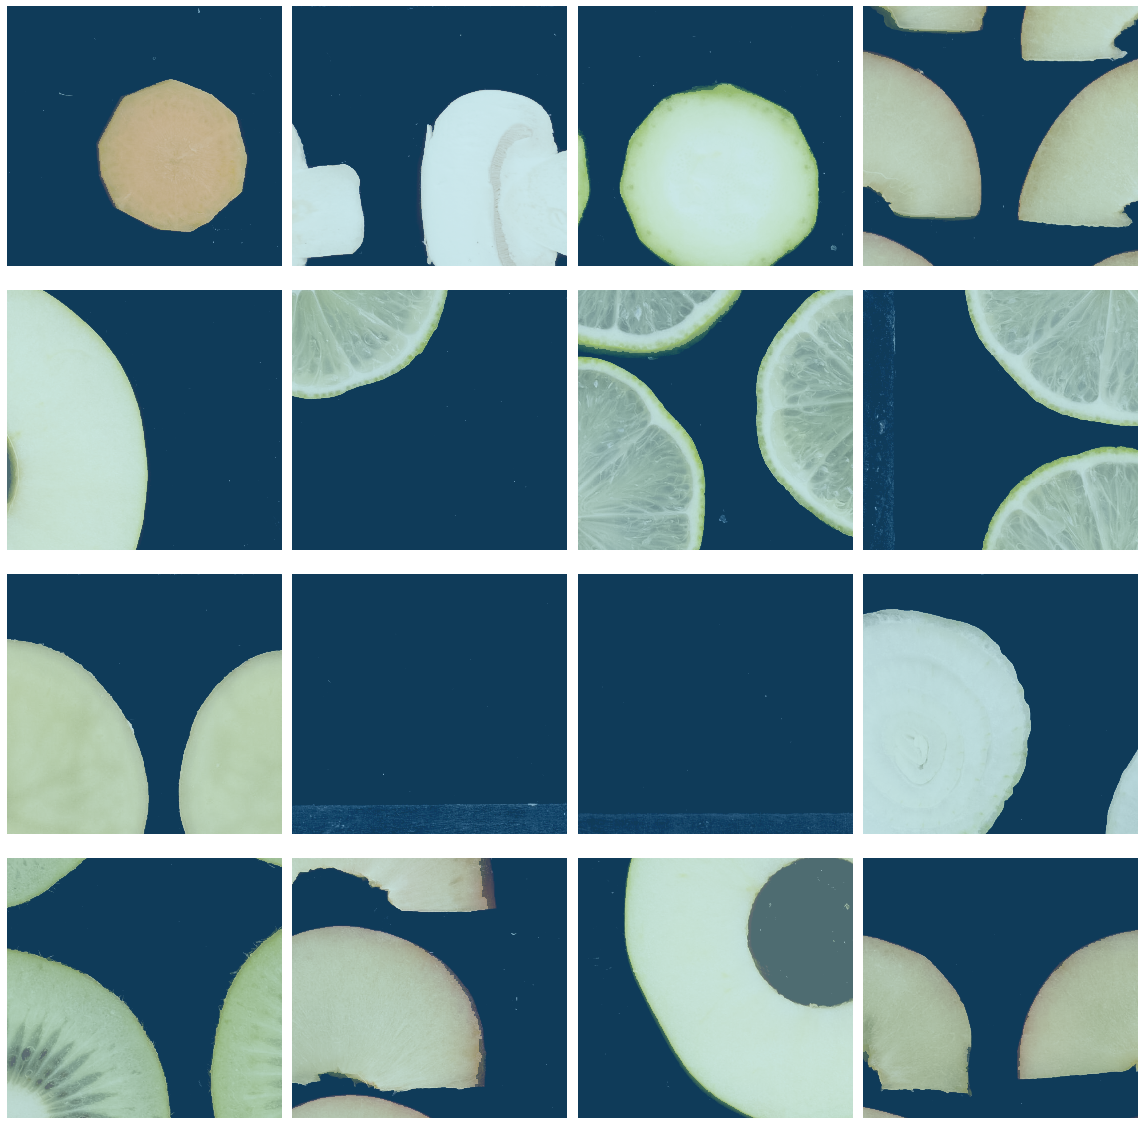

In [11]:
data.show_batch()

In [11]:
learn = unet_learner(data, models.resnet34, metrics=seg_accuracy)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1, 1e-5)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.017942,0.023744,0.992472,38:18


In [12]:
inf_learn = unet_learner(data, models.resnet34, metrics=seg_accuracy).load("1run_test1")

In [12]:
def seg_test_image_tile(img: ImageTile, real_mask: ImageTile):
    pred_mask, _, _ = inf_learn.predict(open_image_tile(img))
    real_mask = open_image_tile(real_mask, div=True, mask=True)
    wrong = np.count_nonzero(pred_mask.data != real_mask.data)
    
    intersection = np.logical_and(real_mask.data, pred_mask.data)
    union = np.logical_or(real_mask.data, pred_mask.data)
    iou_score = torch.div(torch.sum(intersection),torch.sum(union).float())
    
    return iou_score, wrong

In [26]:
#warning img_size: number of pixels
def seg_bench_test_tile(rows, cols, img_size):
    imgs = get_image_files(path_img)
    imgs = get_tiles(imgs, rows, cols)
    masks = [get_labels_tiles(f) for f in imgs]
    wrongs = torch.empty(len(imgs), dtype=torch.float32)
    iou_scores = torch.empty(len(imgs), dtype=torch.float32)
    for i, img, mask in zip(range(len(imgs)), imgs, masks):
        iou_score, wrong = seg_test_image_tile(img, mask)
        wrongs[i] = wrong
        iou_scores[i] = iou_score
                            
    wrong_perc = torch.mean(wrongs) * 100 / img_size
    print(f"perc of wrong pixels: {wrong_perc}%")
    print(f"mean accuracy: {100-wrong_perc}%")
    print(f"max wrong per image: {torch.max(wrongs)} over {img_size} pixels")
    print(f"mean IoU: {torch.mean(iou_scores)}")
    print(f"min IoU: {torch.min(iou_scores)}")

In [32]:
seg_bench_test_tile(4,6, tile_size[0]*tile_size[1])

perc of wrong pixels: 0.7767105102539062%
mean accuracy: 99.2232894897461%
max wrong per image: 38950.0 over 290296 pixels
mean IoU: nan
min IoU: nan


In [16]:
def plot_pixel_difference(img, real_mask, figsize=(20,20)):
    img = open_image_tile(img)
    pred_mask, _, _ = inf_learn.predict(img)
    real_mask = open_image_tile(real_mask, mask=True, div=True)
    real_mask = image2np(real_mask.data)
    pred_mask = image2np(pred_mask.data)

    img = image2np(img.data)
    diff = pred_mask != real_mask
    img[diff==1] = (1, 0 ,0) # 0000FF is blue FF0000 is red
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)

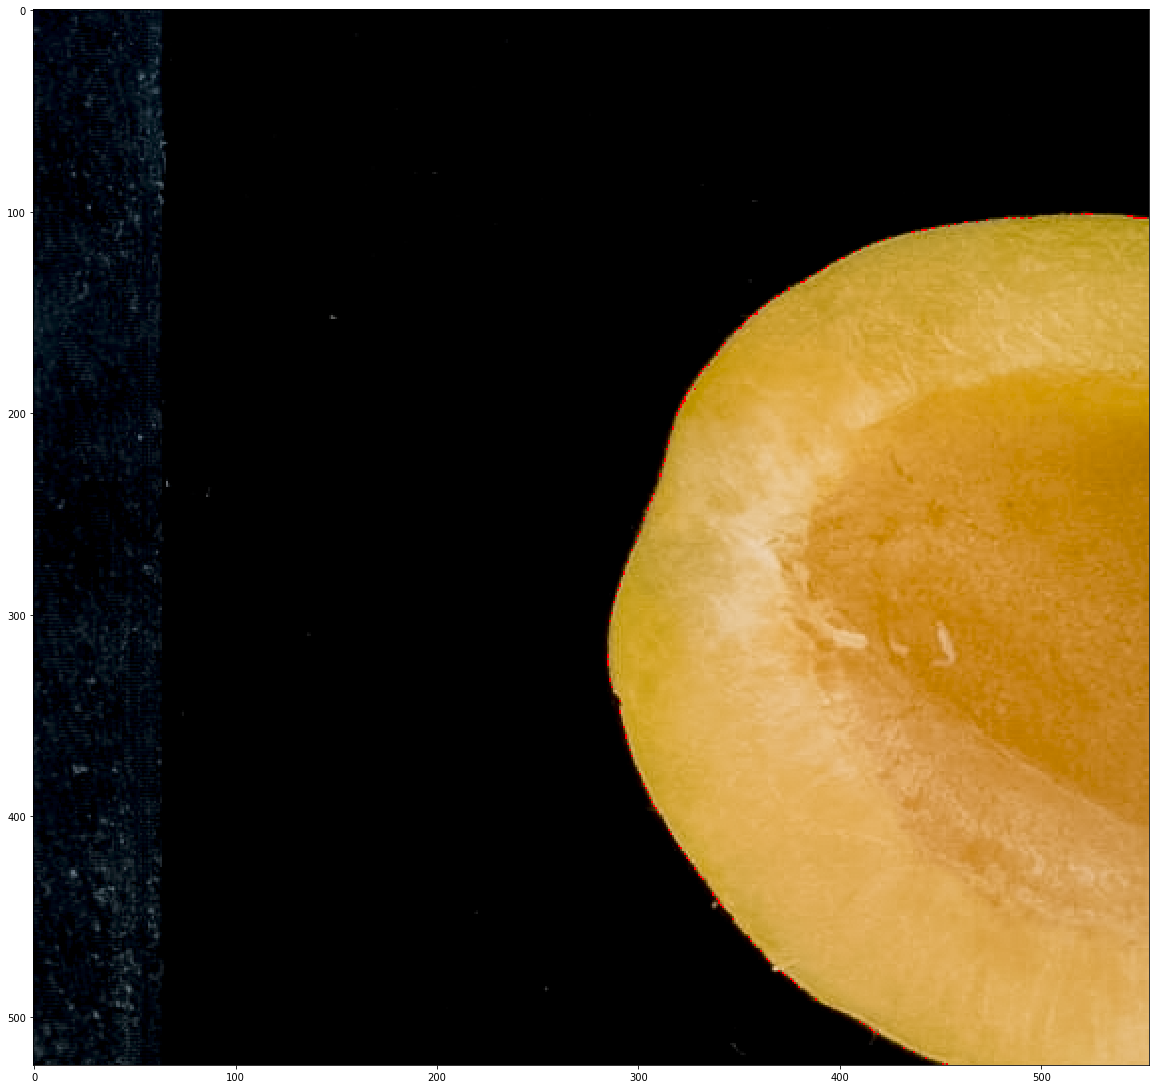

In [17]:
img_path_t = path_img / "albicocche1.png"
img_t = ImageTile(path_img / "albicocche1.png", 0, 4, 6)
mask_t = get_labels_tiles(img_t)
plot_pixel_difference(img_t, mask_t)

In [79]:
#use global variables!!! Refactor please
def pred_mask(img_path, n_rows, n_cols):
    # may preallocate tensors to speed this up
    for row in range(n_rows):
        for col in range(n_cols):
            #print(ImageTile(img_path, row + col*n_rows, n_rows, n_cols))
            img_tile = open_image_tile(ImageTile(img_path, col + row*n_cols, n_rows, n_cols))
            print(col + row*n_cols)
            #mask_tile, _, _ = inf_learn.predict(img_tile)
#             mask_tile = open_image_tile(ImageTile(img_path, col + row*n_cols, n_rows, n_cols))
#             rows_data = torch.cat([rows_data, mask_tile.data], 1) if col else mask_tile.data
#             print(rows_data.shape)
#             show_image(Image(rows_data))
#         cols_data = torch.cat([rows_data, cols_data], 2) if row else rows_data
#         print("done row", cols_data.shape)
#     return Image(cols_data)

In [ ]:
show_image(pred_mask('test_tile.png', 4, 2)) C

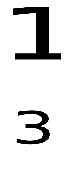

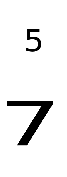

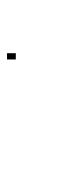

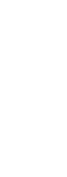

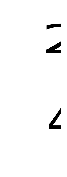

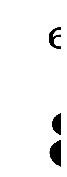

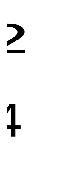

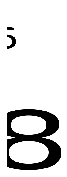

In [88]:
for i in range(8):
    show_image(open_image_tile(('test_tile.png', i, 4, 2)))

In [ ]:
show_image(pred_mask('test_tile.png', 4, 2))

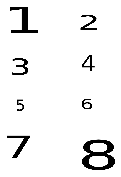

In [78]:
show_image(open_image('test_tile.png'))

In [64]:
open_image(img_path_t).data

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.2000, 0.1725],
         [0.0000, 0.0000, 0.0000,  ..., 0.1451, 0.1804, 0.1216],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.2353, 0.2275],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0824, 0.0431, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.0314, 0.0157],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0039, 0.0078, 0.0157,  ..., 0.2196, 0.2549, 0.2196],
         [0.0078, 0.0039, 0.0078,  ..., 0.1922, 0.2314, 0.1608],
         [0.0078, 0.0039, 0.0039,  ..., 0.2196, 0.2902, 0.2784],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1216, 0.0902, 0.0863],
         [0.0000, 0.0078, 0.0078,  ..., 0.1020, 0.0824, 0.0784],
         [0.0000, 0.0039, 0.0157,  ..., 0.0235, 0.0314, 0.0157]],

        [[0.0745, 0.0784, 0.0824,  ..., 0.2627, 0.3020, 0.2667],
         [0.0784, 0.0745, 0.0745,  ..., 0.2314, 0.2745, 0.1961],
         [0.0784, 0.0745, 0.0706,  ..., 0.2627, 0.3333, 0.

In [65]:
_.dtype

torch.float32